In [2]:

import numpy as np
from tqdm.autonotebook import tqdm
# from prep_text import preprocessing_text
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
keras = tf.keras
print(tf.__version__)
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

2.0.0


In [3]:
SOS_token = 0
EOS_token = 1


class Lang(object):
    def __init__(self, name, n=5, threshold=10):
        self.name = name
        self.word2int = {}
        self.word2count = {}
        self.int2count = {}
        self.int2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2
        self.n = 5
        self.threshold = threshold

    def addWord(self, word):
        if word not in self.word2int:
            self.word2int[word] = self.n_words
            self.word2count[word] = 1
            self.int2count[self.n_words] = 1
            self.int2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            self.int2count[self.word2int[word]] += 1

    def addSentence(self, sentence):
        words = sentence.split(" ")
        for word in words:
            self.addWord(word)

    def word2valid(self, word):
        i = self.word2int[word]
        if i in self.valid:
            return self.valid2int[i]
        else:
            print('Not valid')
            return 0

    def valid2word(self, v):
        return self.int2word[self.int2valid[v]]

    def addText(self, sentences):
        for sentence in sentences:
            self.addSentence(sentence)
        tmp = [np.array([0]), np.array([0])]
        for i in range(2, self.n_words):
            tmp.append(
                np.zeros(self.word2count[self.int2word[i]] * self.n * 2,
                         dtype=np.int))
        self.int2context = np.array(tmp)
        tmp = np.zeros(len(tmp), dtype=np.int)
        for sentence in tqdm(sentences):
            words = sentence.split(" ")
            words = [self.word2int[i] for i in words]
            for i, w in enumerate(tqdm(words, leave=False)):
                if self.word2count[self.int2word[w]] > self.threshold:
                    for j in range(max(i - self.n, 0), i):
                        self.int2context[w][
                            tmp[w]] = words[j] if self.int2count[
                                words[j]] > self.threshold else 0
                        tmp[w] += 1
                    for j in range(i + 1, min(len(words), i + 1 + self.n)):
                        self.int2context[w][
                            tmp[w]] = words[j] if self.int2count[
                                words[j]] > self.threshold else 0
                        tmp[w] += 1
        for i in range(2, self.n_words):
            self.int2context[i] = self.int2context[i][self.int2context[i] != 0]
        self.valid = []
        for i in range(2, self.n_words):
            if self.int2count[i] > self.threshold:
                self.valid.append(i)
        self.n_valid = len(self.valid)
        self.int2valid = {}
        self.valid2int = {}
        for i, v in enumerate(self.valid):
            self.valid2int[v] = i
            self.int2valid[i] = v
        self.valid2context = self.int2context[self.valid]
        for i in tqdm(range(len(self.valid2context))):
            for j in tqdm(range(len(self.valid2context[i])), leave=False):
                self.valid2context[i][j] = self.valid2int[self.valid2context[i]
                                                          [j]]

In [23]:
model = preprocessing_text()

In [10]:
our_folder = 'Books'
file_names = []
for root, dirs, files in tqdm(os.walk(our_folder)):
    file_names.extend([root + '\\' + x for x in files])
file_names = np.array(file_names, dtype=object)
print(len(file_names))


120


In [24]:
def create_generator(file_names, batch_size=128, n=5):
    idxs = np.random.permutation(len(file_names))
    file_names = file_names[idxs]
    #     while True:
    for file in file_names:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                lines = f.readlines()
        except:
            print(file)
            continue
        line = ''.join(lines)
        line = line.replace('\n', ' ')
        line = line.replace('\t', ' ')
        while '  ' in line:
            line = line.replace('  ', ' ')
        while '__' in line:
            line = line.replace('__', '_')
        while '--' in line:
            line = line.replace('--', '-')
        line = model.clear_text(line)
        while '  ' in line:
            line = line.replace('  ', ' ')
        yield line


#         idxs=np.random.permutation(len(file_names))
#         file_names = file_names[idxs]
#         print('All books')

In [12]:
generator = create_generator(file_names)
line = ''.join(generator)
len(line)

44423105

In [13]:
a = list(set(line))
a.sort()
''.join(a)

' !"#$%&\'()*+,-./0123456789:;<=>?@[\\]^_abcdefghijklmnopqrstuvwxyz{|}~£'

In [38]:
lang = Lang('english')
generator = create_generator(file_names)
lang.addText(list(generator))
lang.n_words, lang.n_valid

(57572, 16121)

In [39]:
f = open('lang.pkl', 'wb')
pickle.dump(lang, f)

In [4]:
f = open('lang.pkl', 'rb')
lang = pickle.load(f)

In [5]:
lang.word2valid('she')

181

In [ ]:
lang.

In [7]:
a = np.array(list(lang.word2count.values()))

In [29]:
lang.word2count['i']

182468

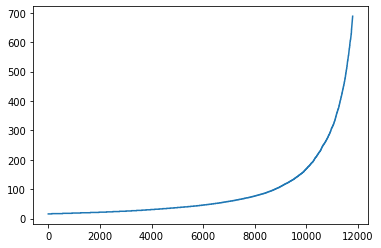

In [20]:
a.sort()
plt.plot(a[45000:-1000])

In [12]:
len(a)

57792

In [16]:
len(a[a > 10])

16159

In [5]:
Dense = keras.layers.Dense
Input = keras.layers.Input
BatchNorm = keras.layers.BatchNormalization
Model = keras.models.Model
Lambda = keras.layers.Lambda
one_hot = keras.utils.to_categorical
LReLU = keras.layers.LeakyReLU

In [18]:
n = 256
def norm(tensor):
    return tf.math.l2_normalize(tensor, axis=-1)
init = 'Orthogonal'
inp = Input(lang.n_valid)
enc = Dense(n, activation=None, kernel_initializer=init)(inp)
enc = Lambda(norm)(enc)
encoder = Model(inp, enc)

In [18]:
encoder.load_weights('encoder_w.h5')

In [12]:
encoder.save_weights('encoder_w.h5')

In [19]:
encInp = Input(n)
dec = Dense(lang.n_valid, activation='softmax')(encInp)
decoder = Model(encInp, dec)

In [20]:
w2v = Dense(lang.n_valid, activation='softmax')(encInp)
word2vecTop = Model(encInp, w2v)

In [21]:
encoded = encoder(inp)
decoded = decoder(encoded)
context = word2vecTop(encoded)
word2vecComb = Model(inp, [decoded, context])
word2vec = Model(inp, context)
autoencoder = Model(inp, decoded)

In [37]:
word2vecComb.load_weights('word2vec_w.h5')

In [22]:
word2vecComb.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 16121)]      0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 256)          4127232     input_4[0][0]                    
__________________________________________________________________________________________________
model_8 (Model)                 (None, 16121)        4143097     model_7[1][0]                    
__________________________________________________________________________________________________
model_9 (Model)                 (None, 16121)        4143097     model_7[1][0]                    
Total params: 12,413,426
Trainable params: 12,413,426
Non-trainable params: 0
_____________

In [12]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 57792)]           0         
_________________________________________________________________
model (Model)                (None, 256)               14795008  
_________________________________________________________________
model_1 (Model)              (None, 57792)             29780928  
Total params: 44,575,936
Trainable params: 44,574,912
Non-trainable params: 1,024
_________________________________________________________________


In [23]:
def create_batch_generator(lang, batch_size=128):
    idxs = np.random.permutation(lang.n_valid)
    batchInp = []
    batchOut1 = []
    batchOut2 = []
    while True:
        for i in idxs:
            batchInp += [i, i, i, i]
            batchOut1 += [i, i, i, i]
            cont = lang.valid2context[i]
            batchOut2 += list(np.random.choice(cont, 4))
            if len(batchInp) >= batch_size:
                yield one_hot(np.array(batchInp),
                              num_classes=lang.n_valid), [
                                  one_hot(np.array(batchOut1),
                                          num_classes=lang.n_valid),
                                  one_hot(np.array(batchOut2),
                                          num_classes=lang.n_valid)
                              ]
                batchInp = []
                batchOut1 = []
                batchOut2 = []
        yield one_hot(np.array(batchInp),
                      num_classes=lang.n_valid), [
                          one_hot(np.array(batchOut1),
                                  num_classes=lang.n_valid),
                          one_hot(np.array(batchOut2),
                                  num_classes=lang.n_valid)
                      ]
        batchInp = []
        batchOut1 = []
        batchOut2 = []
        idxs = np.random.permutation(lang.n_valid)

In [24]:
batch_size = 256

In [25]:
batch_generator = create_batch_generator(lang, batch_size=batch_size)

In [26]:
opt = tf.keras.optimizers.Nadam()

In [27]:
encoder.trainable = True
word2vec.compile(optimizer=opt,
                 loss='categorical_crossentropy',
                 metrics=['acc'])

In [28]:
def create_w2v_generator(lang, batch_size=128):
    idxs = np.random.permutation(lang.n_valid)
    batchInp = []
    batchOut2 = []
    while True:
        for i in idxs:
            batchInp += [i, i, i, i]
            cont = lang.valid2context[i]
            batchOut2 += list(np.random.choice(cont, 4))
            if len(batchInp) >= batch_size:
                yield (one_hot(np.array(batchInp),
                               num_classes=lang.n_valid),
                       one_hot(np.array(batchOut2),
                               num_classes=lang.n_valid))
                batchInp = []
                batchOut2 = []
        yield (one_hot(np.array(batchInp), num_classes=lang.n_valid),
               one_hot(np.array(batchOut2), num_classes=lang.n_valid))
        batchInp = []
        batchOut2 = []
        idxs = np.random.permutation(lang.n_valid)


w2v_gener = create_w2v_generator(lang, batch_size)
training = word2vec.fit_generator(w2v_gener,
                                  verbose=2,
                                  steps_per_epoch=lang.n_valid // batch_size +
                                  1,
                                  epochs=200)

Epoch 1/200
63/63 - 4s - loss: 9.1226 - acc: 0.0578
Epoch 2/200
63/63 - 3s - loss: 7.9666 - acc: 0.0552
Epoch 3/200
63/63 - 3s - loss: 7.1748 - acc: 0.0600
Epoch 4/200
63/63 - 3s - loss: 6.7444 - acc: 0.0553
Epoch 5/200
63/63 - 3s - loss: 6.4944 - acc: 0.0658
Epoch 6/200
63/63 - 3s - loss: 6.4300 - acc: 0.0652
Epoch 7/200
63/63 - 3s - loss: 6.3615 - acc: 0.0624
Epoch 8/200
63/63 - 3s - loss: 6.3528 - acc: 0.0669
Epoch 9/200
63/63 - 3s - loss: 6.3167 - acc: 0.0619
Epoch 10/200
63/63 - 3s - loss: 6.3227 - acc: 0.0608
Epoch 11/200
63/63 - 3s - loss: 6.3358 - acc: 0.0642
Epoch 12/200
63/63 - 3s - loss: 6.3616 - acc: 0.0614
Epoch 13/200
63/63 - 3s - loss: 6.3373 - acc: 0.0631
Epoch 14/200
63/63 - 3s - loss: 6.3362 - acc: 0.0619
Epoch 15/200
63/63 - 3s - loss: 6.3353 - acc: 0.0646
Epoch 16/200
63/63 - 3s - loss: 6.3204 - acc: 0.0634
Epoch 17/200
63/63 - 3s - loss: 6.3245 - acc: 0.0621
Epoch 18/200
63/63 - 3s - loss: 6.3778 - acc: 0.0611
Epoch 19/200
63/63 - 3s - loss: 6.2840 - acc: 0.0637
Ep

Epoch 155/200
63/63 - 3s - loss: 5.9407 - acc: 0.0796
Epoch 156/200
63/63 - 3s - loss: 5.9283 - acc: 0.0817
Epoch 157/200
63/63 - 3s - loss: 5.9192 - acc: 0.0751
Epoch 158/200
63/63 - 3s - loss: 5.9559 - acc: 0.0778
Epoch 159/200
63/63 - 3s - loss: 5.9502 - acc: 0.0771
Epoch 160/200
63/63 - 3s - loss: 5.9559 - acc: 0.0800
Epoch 161/200
63/63 - 3s - loss: 5.9147 - acc: 0.0800
Epoch 162/200
63/63 - 3s - loss: 5.9353 - acc: 0.0804
Epoch 163/200
63/63 - 3s - loss: 5.9310 - acc: 0.0803
Epoch 164/200
63/63 - 3s - loss: 5.9609 - acc: 0.0785
Epoch 165/200
63/63 - 3s - loss: 5.9477 - acc: 0.0778
Epoch 166/200
63/63 - 3s - loss: 5.8943 - acc: 0.0805
Epoch 167/200
63/63 - 3s - loss: 5.8852 - acc: 0.0797
Epoch 168/200
63/63 - 3s - loss: 5.8837 - acc: 0.0863
Epoch 169/200
63/63 - 3s - loss: 5.8714 - acc: 0.0810
Epoch 170/200
63/63 - 3s - loss: 5.8885 - acc: 0.0802
Epoch 171/200
63/63 - 3s - loss: 5.9415 - acc: 0.0784
Epoch 172/200
63/63 - 3s - loss: 5.8768 - acc: 0.0808
Epoch 173/200
63/63 - 3s - l

In [29]:
encoder.trainable = False
autoencoder.compile(optimizer=opt
                    ,
                    loss='categorical_crossentropy',
                    metrics=['acc'])

In [35]:
def create_autoencoder_generator(lang, batch_size=128):
    idxs = np.random.permutation(lang.n_valid)
    batchInp = []
    while True:
        for i in idxs:
            batchInp += [i]
            if len(batchInp) >= batch_size:
                yield (one_hot(np.array(batchInp),
                               num_classes=lang.n_valid),
                       one_hot(np.array(batchInp),
                               num_classes=lang.n_valid))
                batchInp = []
        yield (one_hot(np.array(batchInp),
                       num_classes=lang.n_valid),
               one_hot(np.array(batchInp),
                       num_classes=lang.n_valid))
        batchInp = []
        idxs = np.random.permutation(lang.n_valid)


ae_gener = create_autoencoder_generator(lang, batch_size)
training = autoencoder.fit_generator(ae_gener,
                                     verbose=2,
                                     steps_per_epoch=lang.n_words //
                                     batch_size+1,
                                     epochs=50)

Epoch 1/50
225/225 - 10s - loss: 5.7070 - acc: 0.9602
Epoch 2/50
225/225 - 10s - loss: 5.4165 - acc: 0.9690
Epoch 3/50
225/225 - 10s - loss: 5.1304 - acc: 0.9762
Epoch 4/50
225/225 - 10s - loss: 4.8648 - acc: 0.9810
Epoch 5/50
225/225 - 10s - loss: 4.6069 - acc: 0.9844
Epoch 6/50
225/225 - 10s - loss: 4.3562 - acc: 0.9869
Epoch 7/50
225/225 - 10s - loss: 4.1234 - acc: 0.9895
Epoch 8/50
225/225 - 10s - loss: 3.8873 - acc: 0.9921
Epoch 9/50
225/225 - 10s - loss: 3.6742 - acc: 0.9935
Epoch 10/50
225/225 - 10s - loss: 3.4606 - acc: 0.9947
Epoch 11/50
225/225 - 10s - loss: 3.2578 - acc: 0.9956
Epoch 12/50
225/225 - 10s - loss: 3.0683 - acc: 0.9967
Epoch 13/50
225/225 - 10s - loss: 2.8835 - acc: 0.9974
Epoch 14/50
225/225 - 10s - loss: 2.7089 - acc: 0.9978
Epoch 15/50
225/225 - 10s - loss: 2.5385 - acc: 0.9983
Epoch 16/50
225/225 - 10s - loss: 2.3867 - acc: 0.9987
Epoch 17/50
225/225 - 10s - loss: 2.2357 - acc: 0.9991
Epoch 18/50
225/225 - 10s - loss: 2.0973 - acc: 0.9995
Epoch 19/50
225/225

In [50]:
#word2vecTop.trainable=False
#decoder.trainable=False
encoder.trainable = True
word2vecComb.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
word2vecComb.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 57792)]      0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 256)          14795008    input_3[0][0]                    
__________________________________________________________________________________________________
model_7 (Model)                 (None, 57792)        14852544    model_6[1][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 57792)        14852544    model_6[1][0]                    
Total params: 44,500,096
Trainable params: 44,500,096
Non-trainable params: 0
______________

In [44]:
training = word2vecComb.fit_generator(batch_generator,
                                  verbose=2,
                                  steps_per_epoch=lang.n_words // batch_size+1,
                                  epochs=200)

Epoch 1/200
226/226 - 55s - loss: 19.0947 - model_20_loss: 11.0149 - model_7_loss: 8.0798 - model_20_acc: 0.0000e+00 - model_7_acc: 0.0672
Epoch 2/200
226/226 - 55s - loss: 19.2469 - model_20_loss: 11.1592 - model_7_loss: 8.0876 - model_20_acc: 0.0000e+00 - model_7_acc: 0.0683
Epoch 3/200
226/226 - 55s - loss: 16.4801 - model_20_loss: 8.4381 - model_7_loss: 8.0417 - model_20_acc: 0.0000e+00 - model_7_acc: 0.0674
Epoch 4/200
226/226 - 55s - loss: 8.0716 - model_20_loss: 1.1921e-07 - model_7_loss: 8.0716 - model_20_acc: 0.0000e+00 - model_7_acc: 0.0678
Epoch 5/200
226/226 - 55s - loss: 8.0824 - model_20_loss: 1.1921e-07 - model_7_loss: 8.0824 - model_20_acc: 0.0000e+00 - model_7_acc: 0.0663
Epoch 6/200
226/226 - 55s - loss: 8.0612 - model_20_loss: 1.1921e-07 - model_7_loss: 8.0612 - model_20_acc: 0.0000e+00 - model_7_acc: 0.0680
Epoch 7/200
226/226 - 55s - loss: 8.0688 - model_20_loss: 1.1868e-07 - model_7_loss: 8.0686 - model_20_acc: 6.9444e-05 - model_7_acc: 0.0686
Epoch 8/200
226/226 

KeyboardInterrupt: 

In [87]:
word2vecComb.save_weights('word2vec_w.h5')

In [41]:
def tmp_generator(lang):
    batch = []
    for i in range(lang.n_valid):
        batch.append(i)
        if len(batch)==512:
            yield one_hot(batch, num_classes=lang.n_valid)
            batch=[]
    yield one_hot(batch, num_classes=lang.n_valid)

tmp = tmp_generator(lang)
res = encoder.predict_generator(tmp, steps=(lang.n_valid)//512+1)

In [12]:
def f(i, j):
    return (res[i]*res[j]).sum()

In [84]:
sim = 0
maxI=0
maxJ=0
for i in tqdm(range(lang.n_valid//2)):
    for j in range(i+1, lang.n_valid//2):
        if f(i,j)>sim:
            sim = f(i, j)
            maxI=i
            maxJ=j

In [83]:
(res[lang.word2int['9']-2]*res[lang.word2int['0']-2]).sum()

0.0003878447

In [85]:
sim

0.07995493

In [86]:
lang.int2word[maxI+2], lang.int2word[maxJ+2]

('stalagmite', 'azor')

In [22]:
BS=512
def tmp_generator(lang):
    batch = []
    for i in tqdm(range(lang.n_valid)):
        batch.append(i)
        if len(batch)==BS:
            a = one_hot(batch, num_classes=lang.n_valid)
            yield a, a
            batch=[]
    a = one_hot(batch, num_classes=lang.n_valid)
    yield a, a

tmp = tmp_generator(lang)
autoencoder.evaluate_generator(tmp, steps=(lang.n_valid)//BS+1)

[0.005342846270779403, 0.99977505]

In [29]:
res_decod

[2.8887906534086287, 0.5055544]

In [31]:
BS = 512


def tmp_generator(lang, start, end):
    batch = []
    for i in tqdm(
            range(int((lang.n_valid) * start), int(
                (lang.n_valid) * end))):
        batch.append(i)
        if len(batch) == BS:
            yield one_hot(batch, num_classes=lang.n_valid)
            batch = []
    yield one_hot(batch, num_classes=lang.n_valid)


tmp = tmp_generator(lang, 0, 0.5)
res_decod = autoencoder.predict_generator(tmp,
                                          steps=(lang.n_valid) // BS + 1)

In [32]:
for i in tqdm(range(len(res_decod))):
    if np.argmax(res_decod[i])!=i:
        print(lang.int2word[lang.int2valid[i]], lang.int2word[lang.int2valid[np.argmax(res_decod[i])]])

frigideiro hurrah
fantasy thriller
pick picked
great alot
6 9
wouldn needn
erm croaked
shrieked hurrah
howard carlton
aerocity india
bahia argonaut
lax sfo
angels sox
inn ace
los philadelphia
congratulations congrats
chippendale wales
chocolat choco
contact phone
ac hills
porte maillot
appreciate alot
american southwest
aquaboulevard theme
charpentier hoen
amsterdam aato
wilayah persekutuan
airport jfk
beverly hills
martin garrix
phipps plaza
downtown plaza
primrose star
institution scripps
brandon bruce
telephone phone
yat sen
chinese italian
provide serve
per price
market chestnut
aparthotel amastan
adagio amastan
villette amastan
valjean shattuck
charing amba
ridge blossom
summerlin las
figueroa harrison
greenwich chestnut
terminal authority
leaves return
funston astoria
padres cardinals
diamondbacks cardinals
citi yankee
cubs cardinals
brewers cardinals
cowboys centurylink
financial centurylink
huskies bmo
christopher celio
dodgers cardinals
dodger yankee
cougars utes
husky utes
us

In [91]:
import ipyvolume as ipv

In [92]:
from sklearn.decomposition import PCA

In [93]:
pca = PCA(3)
res = pca.fit_transform(res)

In [94]:
ipv.scatter(res[:,0], res[:,1], res[:,2], size=0.51, marker="sphere")
ipv.show()

In [41]:
res

array([[0.91122115, 0.16535205, 0.2487317 , ..., 0.30931035, 0.32166016,
        0.06460696],
       [0.9223312 , 0.9915253 , 0.08417225, ..., 0.37383986, 0.99773556,
        0.03733301],
       [0.2554105 , 0.9056705 , 0.5375718 , ..., 0.05910093, 0.0043487 ,
        0.8573987 ],
       ...,
       [0.03858128, 0.91633505, 0.11425221, ..., 0.49762166, 0.690143  ,
        0.9425159 ],
       [0.9613259 , 0.4489453 , 0.15751311, ..., 0.15040508, 0.10893911,
        0.9326693 ],
       [0.4650426 , 0.8806407 , 0.4684762 , ..., 0.9293641 , 0.8220339 ,
        0.9532988 ]], dtype=float32)

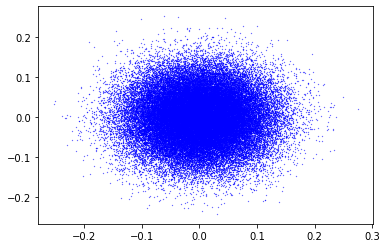

In [57]:
plt.plot(res[:,0], res[:,1], 'b.', ms=0.5)

In [33]:
np.argmax(decoder.predict([[np.zeros(256)]]))

2689

In [51]:
lang.int2word[17292]

'colors'

In [31]:
tmp = tf.math.l2_normalize(np.array([[1, 1, 1], [1, -1, 1]], dtype=np.float32), axis=-1).numpy()

In [34]:
sum(tmp[1]*tmp[1])

0.9999999403953552

In [28]:
d = {1: 0, 2:1}

In [32]:
for i in d:
    print(i)

1
2


In [57]:
def similarity(w1, w2):
    return sum(res[lang.word2valid(w1)]*res[lang.word2valid(w2)])

In [90]:
similarity('talk', 'speak')

0.6856761161572109

In [60]:
len(lang.int2valid)

16121